# A/B Testing: Player Retention for Mobile Game

## Table of Contents

- [1. Intorduction and Context](#1)
- [2. Imports and Helpers](#2)
- [3. Data](#3)
- [4. Exploratory Data Analysis](#4)
    - [4.1. Game Rounds Played](#4.1)
    - [4.2. Retention](#4.2)
- [5. AB Tests](#5)
    - [5.1. Game Rounds](#5.1)
    - [5.2. Day 1 Retention](#5.2)
    - [5.3. Day 7 Retention](#5.3)
- [6. Conclusion](#6)

## 1. Introduction and Context <a name='1'></a>

This is a [mini project](datacamp.com/projects/184) from [DataCamp](datacamp.com). 

### Project Description from DataCamp:

[Cookie Cats](https://tactilegames.com/cookie-cats/) is a hugely popular mobile puzzle game developed by [Tactile Entertainment](https://tactilegames.com). It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or alternatively make an in-app purchase to progress. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.**

🍪 🐈 🍪 🐈 🍪 🐈

### Problem Statement

Should the proposed gate at Level 40 be implemented over the existing gate at Level 40 based on day 1 and 7 player retention rates.

### Data Descriptions

The dataset contains is from 90,189 players that installed the game while the AB Test was running. 

Dataset labels:
- `userid` - `int` - unique player identifier.
- `version` - `str` - group the player was randomly assigned to: control (`gate_30` .- gate at Level 30) or treatment (`gate_40` - gate at Level 40).
- `sum_gamerounds` - `int` - total number of games played by the player during the first week after installation.
- `retention_1` - `bool` - `True` if the player played 1 day after installing else `False`.
- `retention_7` - `bool` - `True` if the player played 7 days after installing else `False`.

## 2. Imports and Helpers<a name='2'></a>

In [1]:
# PyData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Hypothesis Testing
import scipy.stats as stats

In [2]:
# Global Formatting and rendering
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_palette('colorblind')

In [3]:
# Helper Functions

def infoplus(df):
    '''Returns an expanded form of pandas .info() to include,
    shape, null count, null% and unique count'''
    infod = {'col_ind': [], 'col_name': [], 'non_null': [], 'null': [],
             'null_per': [], 'unique': [],'dtype': []}
    max_len = []

    for i, col in enumerate(df.columns):
        infod['col_ind'].append(i)
        infod['col_name'].append(col)
        infod['non_null'].append(df[col].value_counts().sum())
        infod['null'].append(df[col].isna().sum())
        infod['null_per'].append(round(infod['null'][-1] / len(df), 5))
        infod['unique'].append(len(df[col].unique()))
        infod['dtype'].append(str(df[col].dtype))

    for key in infod.keys():
        max_len.append(len(max(map(str, infod[key]), key=len)))
    for i, key in enumerate(infod.keys()):
        max_len[i] = max(len(key), max_len[i])
    if max_len[4] > 6:
        max_len[4] = 6

    OFFSET = 2
    print(type(df))
    print(f'Range Index: {len(df)} entries, {df.index[0]} to {df.index[-1]}')
    print(f'Shape: {df.shape}')
    print(f'''\
{'#': ^{max_len[0] + OFFSET - 2}}\
{'Column': <{max_len[1]}}\
{'Non-Null': >{max_len[2] + OFFSET}}\
{'Null': >{max_len[3] + OFFSET}}\
{'% Null': >{max_len[4] + OFFSET}}\
{'Unique': >{max_len[5] + OFFSET}}  \
{'dtype': <{max_len[6] + OFFSET}}\
''')
    print(f'''\
{'-' * (max(3, max_len[0]) - 2): ^{max_len[0] + OFFSET - 2}}\
{'-' * max_len[1]: <{max_len[1]}}\
{'-' * max_len[2]: >{max_len[2] + OFFSET}}\
{'-' * max_len[3]: >{max_len[3] + OFFSET}}\
{'-' * max_len[4]: >{max_len[4] + OFFSET}}\
{'-' * max_len[5]: >{max_len[5] + OFFSET}}  \
{'-' * max_len[6]: <{max_len[6] + OFFSET}}\
''')
    for i in infod['col_ind']:
        print(f'''{str(infod['col_ind'][i]): ^{max(3, max_len[0] + OFFSET - 2)}}\
{infod['col_name'][i]: <{max_len[1]}}\
{infod['non_null'][i]: >{max_len[2] + OFFSET}}\
{infod['null'][i]: >{max_len[3] + OFFSET}}\
{f"{infod['null_per'][i] * 100: .2f}": >{max_len[4] + OFFSET}}\
{infod['unique'][i]: >{max_len[5] + OFFSET}}  \
{infod['dtype'][i]: <{max_len[6] + OFFSET}}\
              ''')
    
    dtypes = [dtype for dtype in set(infod['dtype'])]
    for dtype in dtypes:
        dtype_count = [f"{dtype}({infod['dtype'].count(dtype)})" for dtype in dtypes]
    print(f"dtypes: {', '.join(dtype_count)}")
    print(f'memory usage: {byte_conversion(df.memory_usage().sum())}')
    
# Helper
def byte_conversion(df_mem):
    '''Converts bytes to readable magnitude, used in infoplus()'''
    ending_dict = {1: 'B', 2: 'KB', 3: 'MB', 4: 'GB'}
    power = 1
    while df_mem / (1024 ** power) > 1:
        power += 1
        if power == 4:
            break
    return f'{df_mem / (1024 ** (power - 1)): .2f} {ending_dict[power]}'

## 3. Data <a name='3'></a>

In [4]:
data = pd.read_csv('../raw_data/cookie_cats.csv')

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# Check dataframe shape, null counts and unique values, datatypes
infoplus(data)

<class 'pandas.core.frame.DataFrame'>
Range Index: 90189 entries, 0 to 90188
Shape: (90189, 5)
   #   Column          Non-Null  Null  % Null  Unique  dtype   
 ----- --------------  --------  ----  ------  ------  ------  
   0   userid             90189     0    0.00   90189  int64                 
   1   version            90189     0    0.00       2  object                
   2   sum_gamerounds     90189     0    0.00     942  int64                 
   3   retention_1        90189     0    0.00       2  bool                  
   4   retention_7        90189     0    0.00       2  bool                  
dtypes: object(1), int64(2), bool(2)
memory usage:  2.24 MB


In [6]:
rows = {'rows': False}

list(rows.values())[0]

False

In [7]:
# Check duplicates within data frame and duplicated users
def duplicated_rows_check(df):
    rows = {'name' : 'rows', 'value': False}
    users = {'name' : 'users', 'value': False}
    if df.duplicated().sum() == 0:
        rows['value'] = True
    if df['userid'].duplicated().sum() == 0:
        users['value'] = True
    for check in [rows, users]:
        print(f"No duplicate {check['name']} present." if check['value'] == True
              else f"Duplicate {check['name']} present.")
    return rows['value'], users['value']
    
duplicated_rows_check(data)

No duplicate rows present.
No duplicate users present.


(True, True)

### Dataset Balance

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


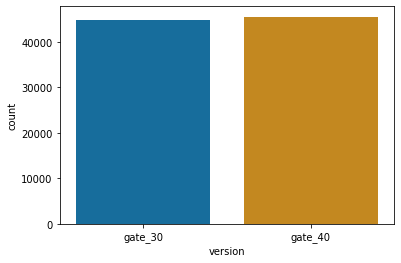

In [8]:
# Coount of players in control and treatment group w/ visualisation

display(data.groupby('version').count())

sns.countplot(x='version', data=data)
plt.show()

In [9]:
# Percentage of players in control and treatment groups

control, treatment = data['version'].value_counts()[0], data['version'].value_counts()[1]
print(f'{control / data.shape[0] * 100:.2f}% of users in control group')
print(f'{treatment / data.shape[0] * 100:.2f}% of users in treatment group')

50.44% of users in control group
49.56% of users in treatment group


Spread of randomly assigned players looks even, though Sample Ratio Mismatch (SRM), could still be present. I will not be performing a SRM analysis, but this could be performed with a Chi-squared goodness of fit test.

Observations:
- There are no null values.
- `version`, `retention_1` and `retention_7` have binary values as expected.
- There are no duplicate entries or duplicated users.
- The dataset looks relatively balanced.
- Data is generally clean and ready to use.

## 4. Exploratory Data Analysis <a name='4'></a>

There are two primary explanations that we can perform, the first with the number of game rounds played and the second with the 1 and 7 day retention rates.

### 4.1 EDA - Game Rounds Played <a name ='4.1'></a>

Lets look at the `sum_gamerounds` played for each player, first as a whole of the dataset and then by experiment group.

In [10]:
# Desptive statistics of the entire data set to get an idea of the distribution

data[['sum_gamerounds']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.000,51.872,195.051,0.000,5.000,16.000,51.000,49854.000


In [11]:
# Grouped by control and treatment groups

data.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'median', 'std', 'max'])

,count,mean,median,std,max
version,,,,,
gate_30,44700,52.456,17.000,256.716,49854
gate_40,45489,51.299,16.000,103.294,2640


Looking at the two groups visually, we can see there is an outlier in the `gate_30` group. This will be skewing the data.

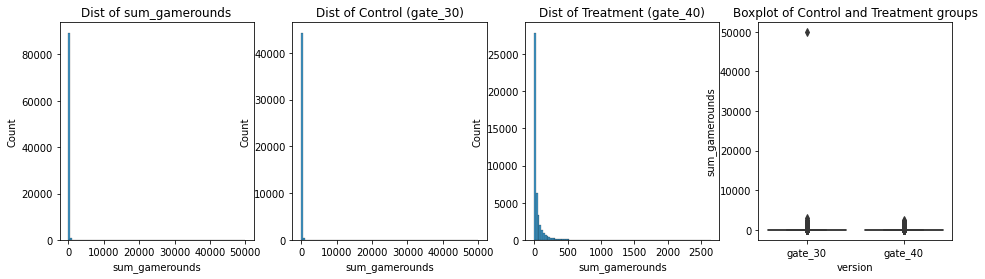

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(data['sum_gamerounds'], bins=100, ax=axes[0])
sns.histplot(data[data['version'] == 'gate_30']['sum_gamerounds'], bins=100, ax=axes[1])
sns.histplot(data[data['version'] == 'gate_40']['sum_gamerounds'], bins=100, ax=axes[2])
sns.boxplot(x='version', y='sum_gamerounds', data=data, ax=axes[3])

axes[0].set_title('Dist of sum_gamerounds')
axes[1].set_title('Dist of Control (gate_30)')
axes[2].set_title('Dist of Treatment (gate_40)')
axes[3].set_title('Boxplot of Control and Treatment groups')
plt.show()

In [13]:
# Binning sum_gamerounds into 5 arbitrary size bins to get a feel for how many outliers there are

rounds_bins = pd.cut(data['sum_gamerounds'], 5, labels=[i+1 for i in range(5)])
rounds_bins.value_counts().sort_index()

1    90188
2        0
3        0
4        0
5        1
Name: sum_gamerounds, dtype: int64

This means that if the data was sorted into 5 arbitrary but equal bins by `sum_gamecount`, 90,188 of the values would be in bin one, and one value would be in bin five, with no values in bins two, three, or four. 

The data is telling us that a user played ~50,000 games in the first week after downloading, which if true, is kinda impressive. I am are going to remove the outlier.

In [14]:
data = data[data['sum_gamerounds'] < data['sum_gamerounds'].max()]

In [15]:
# Checking descriptive stats of without outlier

display(data.describe().T)
display(data.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'median', 'std', 'max']))

,count,mean,std,min,25%,50%,75%,max
userid,90188.000,4998396.798,2883297.866,116.000,2512211.250,4995804.000,7496460.750,9999861.000
sum_gamerounds,90188.000,51.320,102.683,0.000,5.000,16.000,51.000,2961.000


,count,mean,median,std,max
version,,,,,
gate_30,44699,51.342,17.000,102.058,2961
gate_40,45489,51.299,16.000,103.294,2640


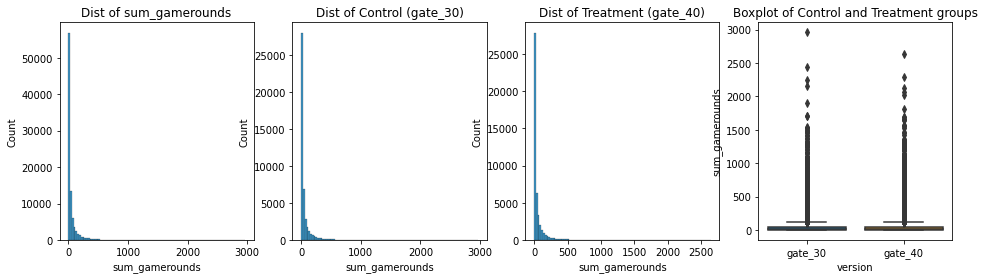

In [16]:
# Re-plotting without outlier

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(data['sum_gamerounds'], bins=100, ax=axes[0])
sns.histplot(data[data['version'] == 'gate_30']['sum_gamerounds'], bins=100, ax=axes[1])
sns.histplot(data[data['version'] == 'gate_40']['sum_gamerounds'], bins=100, ax=axes[2])
sns.boxplot(x='version', y='sum_gamerounds', data=data, ax=axes[3])

axes[0].set_title('Dist of sum_gamerounds')
axes[1].set_title('Dist of Control (gate_30)')
axes[2].set_title('Dist of Treatment (gate_40)')
axes[3].set_title('Boxplot of Control and Treatment groups')
plt.show()

Boxplots and some stats (mean, std) look more representative of the sample. There is still a skew.

### Univariate - Gamerounds played

Starting with the number of players to reach n rounds and a cumulative sum.

In [17]:
# Cumulative sum
def create_gamerounds(df):
    '''Return a dataframe with sum_gamerounds, cound, percent_count, cumsum, percent_cumsum'''
    gamerounds = df.groupby('sum_gamerounds')['userid'].agg(['count']).reset_index()
    gamerounds['percent_count'] = gamerounds['count'] / df.shape[0] * 100
    gamerounds['cumsum'] = gamerounds['count'].cumsum()
    gamerounds['percent_cumsum'] = gamerounds['cumsum'] / df.shape[0] * 100
    return gamerounds
    
gamerounds_tot = create_gamerounds(data)

In [18]:
gamerounds_tot.head(20)

,sum_gamerounds,count,percent_count,cumsum,percent_cumsum
0,0,3994,4.429,3994,4.429
1,1,5538,6.141,9532,10.569
2,2,4606,5.107,14138,15.676
3,3,3958,4.389,18096,20.065
4,4,3629,4.024,21725,24.089
5,5,2992,3.318,24717,27.406
6,6,2861,3.172,27578,30.578
7,7,2379,2.638,29957,33.216
8,8,2267,2.514,32224,35.730
9,9,2013,2.232,34237,37.962


Looking graphically at the a distribution of all players who played between 0 and 100 game rounds (~86 of the sample)

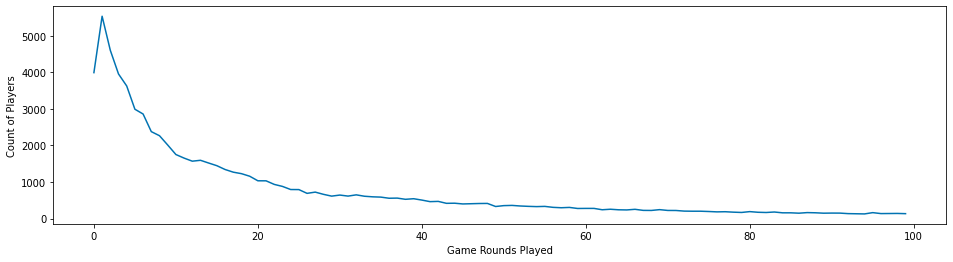

In [19]:
ax = gamerounds_tot[:100].plot(x='sum_gamerounds', y='count', legend=False, figsize=(16,4))
ax.set_xlabel('Game Rounds Played')
ax.set_ylabel('Count of Players')
plt.show()

### Bivariate - gamerounds played

Insights might be derived from inspecting gamerounds played with respect to group to see if there is an obvious link to retention.

In [20]:
gamerounds_cont = create_gamerounds(data[data['version'] == 'gate_30'])
gamerounds_trea = create_gamerounds(data[data['version'] == 'gate_40'])

display(gamerounds_cont.head(20), gamerounds_trea.head(20))

,sum_gamerounds,count,percent_count,cumsum,percent_cumsum
0,0,1937,4.333,1937,4.333
1,1,2749,6.150,4686,10.483
2,2,2198,4.917,6884,15.401
3,3,1899,4.248,8783,19.649
4,4,1831,4.096,10614,23.745
5,5,1442,3.226,12056,26.972
6,6,1420,3.177,13476,30.148
7,7,1199,2.682,14675,32.831
8,8,1162,2.600,15837,35.430
9,9,998,2.233,16835,37.663


,sum_gamerounds,count,percent_count,cumsum,percent_cumsum
0,0,2057,4.522,2057,4.522
1,1,2789,6.131,4846,10.653
2,2,2408,5.294,7254,15.947
3,3,2059,4.526,9313,20.473
4,4,1798,3.953,11111,24.426
5,5,1550,3.407,12661,27.833
6,6,1441,3.168,14102,31.001
7,7,1180,2.594,15282,33.595
8,8,1105,2.429,16387,36.024
9,9,1015,2.231,17402,38.255


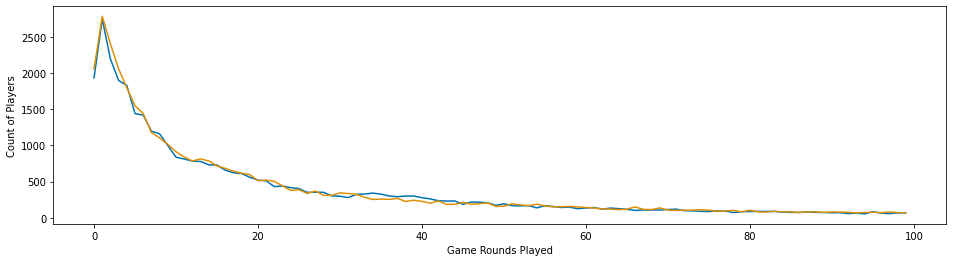

In [21]:
# Graphically for users who played up to 100 game rounds:

fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(x='sum_gamerounds', y='count', data=gamerounds_cont[:100], ax=ax)
sns.lineplot(x='sum_gamerounds', y='count', data=gamerounds_trea[:100], ax=ax, palette='Or')
ax.set_xlabel('Game Rounds Played')
ax.set_ylabel('Count of Players')
plt.show()

### Observations on rounds played

All values are with respect to the week after installation. 

There are no obvious links between gamerounds played and the group the player was assigned to.

The number of players decreases as levels increase. The exception is that a number of players installed the game and did not complete any levels (installed and did not play).
- 3,994 (~4.4%) players did not play the game
- ~27.4% of players played five or less rounds
- 50% of players played 16 or less rounds
- 75% of players played less than 50 rounds

These values can be explored by themselves, especially the 3,994 players installing the game and not playing in the week following installation, in addition over a quarter of players in the sample played 5 rounds or less in the week following installation. Possible reasons may include but aren't limited to:
- Players didn't like the game or aspect of the game (mechanics/aesthetics/music/story?).
- Difficulty increased as levels progressed and locked players out.
- Dodn't like the free-mium model.
- Product was not as advertised.
- Players haven't had an opportunity to play the game.

With churn happening at relatively low number of rounds played, there is an opportunity to increase retention. Fact finding (exit surveys) and incentives could lead to higher retention rates. More research is required.

### 4.2 EDA - Retention <a name ='4.2'></a>

In [22]:
# Looking at all players

pd.DataFrame({'retention_1_count': data['retention_1'].value_counts(),
             'retention_1_perc': data['retention_1'].value_counts() / data.shape[0],
             'retention_7_count': data['retention_7'].value_counts(),
             'retention_7_perc': data['retention_7'].value_counts() / data.shape[0]}).reset_index()


,index,retention_1_count,retention_1_perc,retention_7_count,retention_7_perc
0,False,50035,0.555,73408,0.814
1,True,40153,0.445,16780,0.186


In [23]:
# 1 Day Retention by group

reten_1 = data.groupby(['version', 'retention_1'])['sum_gamerounds'].agg(['mean', 'median', 'std', 'max', 'count'])
reten_1['ratio'] = reten_1.groupby(level=0).apply(lambda x: x / x.sum())['count']
reten_1

mean  median     std   max  count  ratio
version retention_1                                           
gate_30 False       16.359   6.000  36.528  1072  24665  0.552
        True        94.412  48.000 135.038  2961  20034  0.448
gate_40 False       16.340   6.000  35.926  1241  25370  0.558
        True        95.381  49.000 137.887  2640  20119  0.442

In [24]:
# 7 Day Retention by group

reten_7 = data.groupby(['version', 'retention_7'])['sum_gamerounds'].agg(['mean', 'median', 'std', 'max', 'count'])
reten_7['ratio'] = reten_7.groupby(level=0).apply(lambda x: x / x.sum())['count']
reten_7

mean  median     std   max  count  ratio
version retention_7                                            
gate_30 False        25.797  11.000  43.316   981  36198  0.810
        True        160.118 105.000 179.359  2961   8501  0.190
gate_40 False        25.856  11.000  44.406  2640  37210  0.818
        True        165.650 111.000 183.792  2294   8279  0.182

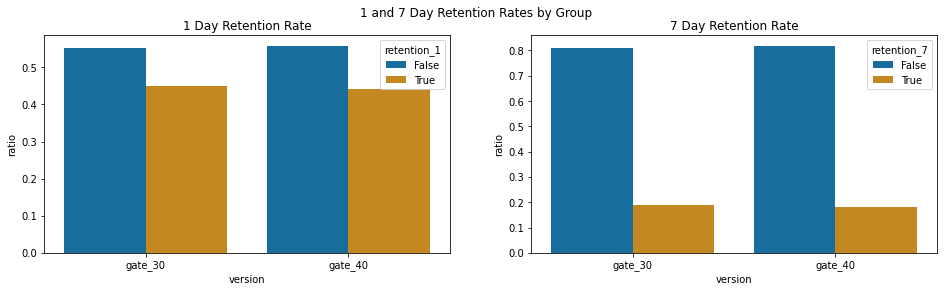

In [25]:
# 1 and 7 day by treatment group graphically

fig, axes = plt.subplots(1, 2, figsize=(16,4))
sns.barplot(x='version', y='ratio', data=reten_1.reset_index(), hue='retention_1', ax=axes[0])
sns.barplot(x='version', y='ratio', data=reten_7.reset_index(), hue='retention_7', ax=axes[1])

plt.suptitle('1 and 7 Day Retention Rates by Group')
axes[0].set_title('1 Day Retention Rate')
axes[1].set_title('7 Day Retention Rate')
plt.show()

In [26]:
# Looking at both day 1 and 7 values together

reten_both = data.groupby(['version', 'retention_1', 'retention_7'])['sum_gamerounds'].agg(['mean', 'median', 'std', 'max', 'count'])
reten_both['ratio'] = reten_both.groupby(level=0).apply(lambda x: x / x.sum())['count']
reten_both

mean  median     std   max  count  ratio
version retention_1 retention_7                                            
gate_30 False       False        11.820   6.000  21.643   981  22840  0.511
                    True         73.169  43.000  93.222  1072   1825  0.041
        True        False        49.694  33.000  58.125   918  13358  0.299
                    True        183.886 127.000 189.626  2961   6676  0.149
gate_40 False       False        11.913   6.000  20.901   547  23597  0.519
                    True         75.261  47.000  94.478  1241   1773  0.039
        True        False        50.025  32.000  60.925  2640  13613  0.299
                    True        190.282 133.000 194.220  2294   6506  0.143

In [27]:
# Add a column with 1 and 7 Day Retention Bools
reten_both['retention_1_str'] = np.where(reten_both.reset_index()['retention_1'] == True, 'True', 'False')
reten_both['retention_7_str'] = np.where(reten_both.reset_index()['retention_7'] == True, 'True', 'False')
reten_both['reten_both'] = reten_both['retention_1_str'].str.cat(reten_both['retention_7_str'], '-')
reten_both.drop(columns=['retention_1_str', 'retention_7_str'], inplace=True)
# test['reten_both'] = test['retention_1'].apply(lambda x, y: f"{str(x)}+{str(y)}", test['retention_7'], axis=1)
reten_both

mean  median     std   max  count  ratio  \
version retention_1 retention_7                                               
gate_30 False       False        11.820   6.000  21.643   981  22840  0.511   
                    True         73.169  43.000  93.222  1072   1825  0.041   
        True        False        49.694  33.000  58.125   918  13358  0.299   
                    True        183.886 127.000 189.626  2961   6676  0.149   
gate_40 False       False        11.913   6.000  20.901   547  23597  0.519   
                    True         75.261  47.000  94.478  1241   1773  0.039   
        True        False        50.025  32.000  60.925  2640  13613  0.299   
                    True        190.282 133.000 194.220  2294   6506  0.143   

                                  reten_both  
version retention_1 retention_7               
gate_30 False       False        False-False  
                    True          False-True  
        True        False         True-False  
                    True           True-True  
gate_40 False       False        False-False  
                    True          False-True  
        True        False         True-False  
                    True           True-True

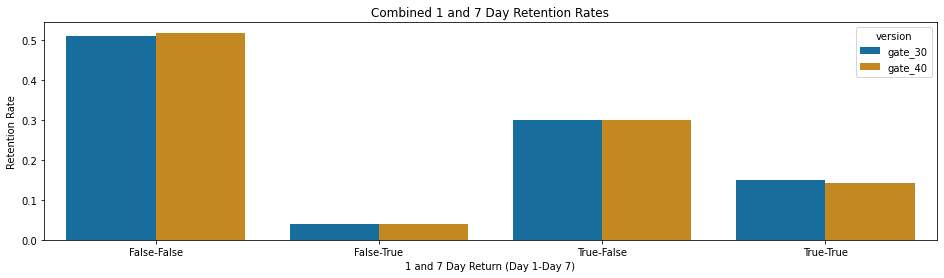

In [28]:
# Looking at combined 1 and 7 Day Retention Rates

fig, ax = plt.subplots(figsize=(16,4))
sns.barplot(x='reten_both', y='ratio', data=reten_both.reset_index(), hue='version', ax=ax)
ax.set_title('Combined 1 and 7 Day Retention Rates')
ax.set_xlabel('1 and 7 Day Return (Day 1-Day 7)')
ax.set_ylabel('Retention Rate')

plt.show()

### Retention Rate Observations

Considering the entire sample, the 1 and 7 Day Retention Rate of 0.445 and 0.186. 

Graphically, there is not much to see. Numerically, the values for Day 1 and Day 7 retention rates are slightly higher for the control group,  `gate_30`, with a 1 and 7 Day retention rate of 0.448 and 0.190 respectively, above the Retention rates for the entire sample, compared with the the treatment group, `gate_40`, rates of 0.442 and 0.182. 

AB tests will be performed to see if these values are statistically significant or not.

Looking at the combined 1 and 7 Day Retention Rates, it looks like slightly more players assigned to the control group, `gate_30`, played the game both on Day 1 and with 7 Days (True-True), and more players assigned to the treatment group, `gate_40`, played neither on Day 1 or Day 7 (False-False) 

## 5. AB Tests <a name ='5'></a>

The business question relates specifically to changing the gates based on the day 1 and 7 retention rates. We can also perform an A/B test on sum_gamerounds to check if there is a statistically significant difference in the number of gamerounds played based on assigned group.

Therefore, A/B tests on three separate targets: `retention_1`, `retention_7`, and `sum_gamerounds`

The general structure will be:
- Check distribution normalcy of the target with a Shapiro-Wilks test.
- If normaly distributed with similar variance, apply Parametric test: students t-test or z test.
- If not normaly distributed, apply Non-Parametric test: Mann-Whitney U test.

### 5.1 Game Rounds <a name ='5.1'></a>
The distribution of gamerounds played is quite clearly not normally distributed, but we can perform a Shapiro-Wilks test to confirm.

### 5.2 Day 1 Retention <a name ='5.2'></a>

### 5.3 Day 7 Retention <a name ='5.3'></a>

## 6. Conclusion <a name ='6'></a>